/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Fold 1 - Accuracy on test set: 0.9367176634214186


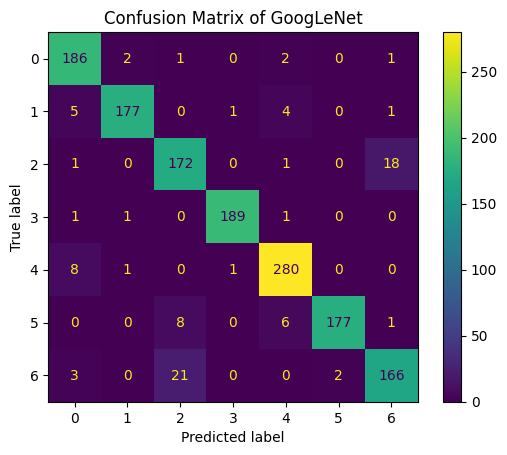

Fold 2 - Accuracy on test set: 0.9388038942976356


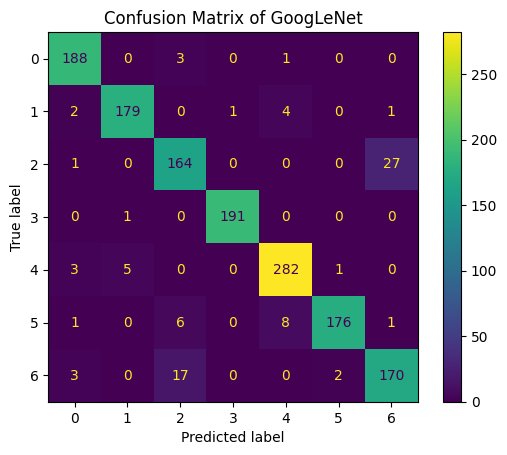

Fold 3 - Accuracy on test set: 0.933240611961057
Fold 4 - Accuracy on test set: 0.9464161447459986


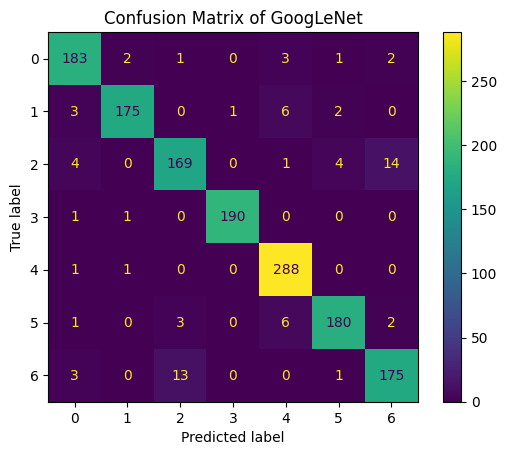

Fold 5 - Accuracy on test set: 0.9464161447459986
Best macro ROC and PR curves data saved successfully.


In [1]:
import os
import numpy as np
import gc
import matplotlib.pyplot as plt
from skimage import io
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, roc_curve, auc, precision_recall_curve, confusion_matrix, ConfusionMatrixDisplay
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import DataLoader, Dataset
import warnings

warnings.filterwarnings("ignore")

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

seed = 7
set_seed(seed)

IMG_EXTENSIONS = ('.jpg', '.jpeg', '.png')

def is_image_file(filename):
    return filename.lower().endswith(IMG_EXTENSIONS)

def find_classes(dir):
    classes = [d.name for d in os.scandir(dir) if d.is_dir()]
    classes.sort()
    class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}
    return classes, class_to_idx

def func(dir):
    classes, class_to_idx = find_classes(dir)
    imgs = []
    labels = []
    for target_class in sorted(class_to_idx.keys()):
        class_index = class_to_idx[target_class]
        target_dir = os.path.join(dir, target_class)
        if not os.path.isdir(target_dir):
            continue
        for root, _, fnames in sorted(os.walk(target_dir, followlinks=True)):
            for fname in sorted(fnames):
                if is_image_file(fname):
                    path = os.path.join(root, fname)
                    imgs.append(path)
                    labels.append(class_index)
    return imgs, labels

class ImageDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = io.imread(image_path)
        if len(image.shape) == 2:
            image = np.stack([image] * 3, axis=-1)
        if self.transform:
            image = self.transform(image)
        label = self.labels[idx]
        return image, label

transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
])

dir_train = "200new/200/train"
dir_test = "200new/200/test"

train_list = func(dir_train)
test_list = func(dir_test)

img = train_list[0] + test_list[0]
labels = train_list[1] + test_list[1]

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=7)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

best_accuracy = 0
best_fpr = None
best_tpr = None
best_roc_auc = None
best_precision = None
best_recall = None
best_pr_auc = None

for fold, (train_index, test_index) in enumerate(skf.split(img, labels)):
    train_img_paths = [img[i] for i in train_index]
    test_img_paths = [img[i] for i in test_index]
    train_labels = [labels[i] for i in train_index]
    test_labels = [labels[i] for i in test_index]

    train_dataset = ImageDataset(train_img_paths, train_labels, transform)
    test_dataset = ImageDataset(test_img_paths, test_labels, transform)

    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)  # 减小batch size
    test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

    model = models.googlenet(pretrained=True)
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, len(np.unique(labels)))

    for param in model.parameters():
        param.requires_grad = False
    for param in model.fc.parameters():
        param.requires_grad = True

    model = model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.fc.parameters(), lr=0.0001)
    scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda epoch: 0.9 ** epoch)

    model.train()
    accumulation_steps = 2  # 使用梯度累积
    optimizer.zero_grad()
    for epoch in range(100):
        for i, (inputs, targets) in enumerate(train_loader):
            inputs, targets = inputs.to(device, non_blocking=True), targets.to(device, non_blocking=True)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss = loss / accumulation_steps
            loss.backward()
            if (i+1) % accumulation_steps == 0:
                optimizer.step()
                optimizer.zero_grad()
        scheduler.step()

    model.eval()
    all_labels = []
    all_predictions = []
    all_probabilities = []
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device, non_blocking=True), targets.to(device, non_blocking=True)
            outputs = model(inputs)
            probabilities = torch.softmax(outputs, dim=1)
            _, preds = torch.max(outputs, 1)
            all_labels.extend(targets.cpu().numpy())
            all_predictions.extend(preds.cpu().numpy())
            all_probabilities.extend(probabilities.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_predictions)
    print(f"Fold {fold + 1} - Accuracy on test set: {accuracy}")

    if accuracy > best_accuracy:
        best_accuracy = accuracy
        plt.figure()
        conf_matrix = confusion_matrix(all_labels, all_predictions)
        disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=np.unique(labels))
        disp.plot(ax=plt.gca())
        plt.title('Confusion Matrix of GoogLeNet')
        plt.savefig('Deep learning/GoogLeNet/confusion_matrix.png', dpi=300, bbox_inches='tight')
        plt.show()
        plt.close()

        test_labels_bin = label_binarize(all_labels, classes=np.unique(labels))
        all_fpr = np.unique(np.concatenate([roc_curve(test_labels_bin[:, i], np.array(all_probabilities)[:, i])[0] for i in range(test_labels_bin.shape[1])]))
        mean_tpr = np.zeros_like(all_fpr)

        fpr, tpr, roc_auc = {}, {}, {}
        for i in range(test_labels_bin.shape[1]):
            fpr[i], tpr[i], _ = roc_curve(test_labels_bin[:, i], np.array(all_probabilities)[:, i])
            mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
            roc_auc[i] = auc(fpr[i], tpr[i])

        mean_tpr /= test_labels_bin.shape[1]
        fpr["macro"] = all_fpr
        tpr["macro"] = mean_tpr
        roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

        all_recall = np.unique(np.concatenate([precision_recall_curve(test_labels_bin[:, i], np.array(all_probabilities)[:, i])[1] for i in range(test_labels_bin.shape[1])]))
        mean_precision = np.zeros_like(all_recall)

        precision, recall, pr_auc = {}, {}, {}
        for i in range(test_labels_bin.shape[1]):
            precision[i], recall[i], _ = precision_recall_curve(test_labels_bin[:, i], np.array(all_probabilities)[:, i])
            mean_precision += np.interp(all_recall, recall[i][::-1], precision[i][::-1])
            pr_auc[i] = auc(recall[i], precision[i])

        mean_precision /= test_labels_bin.shape[1]
        precision["macro"] = mean_precision
        recall["macro"] = all_recall
        pr_auc["macro"] = auc(recall["macro"], precision["macro"])

        best_fpr = fpr
        best_tpr = tpr
        best_roc_auc = roc_auc
        best_precision = precision
        best_recall = recall
        best_pr_auc = pr_auc

    gc.collect()
    torch.cuda.empty_cache()

np.save('Deep learning/GoogLeNet/best_fpr.npy', best_fpr)
np.save('Deep learning/GoogLeNet/best_tpr.npy', best_tpr)
np.save('Deep learning/GoogLeNet/best_roc_auc.npy', best_roc_auc)
np.save('Deep learning/GoogLeNet/best_precision.npy', best_precision)
np.save('Deep learning/GoogLeNet/best_recall.npy', best_recall)
np.save('Deep learning/GoogLeNet/best_pr_auc.npy', best_pr_auc)

print("Best macro ROC and PR curves data saved successfully.")


In [4]:
import gc
gc.collect()
torch.cuda.empty_cache()
